## data preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

In [2]:
!mkdir ./data
data_dir = './data'

name_input = 'train-volume.tif'
name_label = 'train-labels.tif'

mkdir: cannot create directory ‘./data’: File exists


In [3]:
images = Image.open(os.path.join(data_dir, name_input))
labels = Image.open(os.path.join(data_dir, name_label))

In [4]:
h, w = images.size
nframe = images.n_frames
print(h, w, nframe)

512 512 30


In [5]:
train = os.path.join(data_dir, 'train')
val = os.path.join(data_dir, 'val')
test = os.path.join(data_dir, 'test')

In [6]:
for dir in [train, val, test]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [7]:
frame_id = np.arange(nframe)
np.random.shuffle(frame_id)

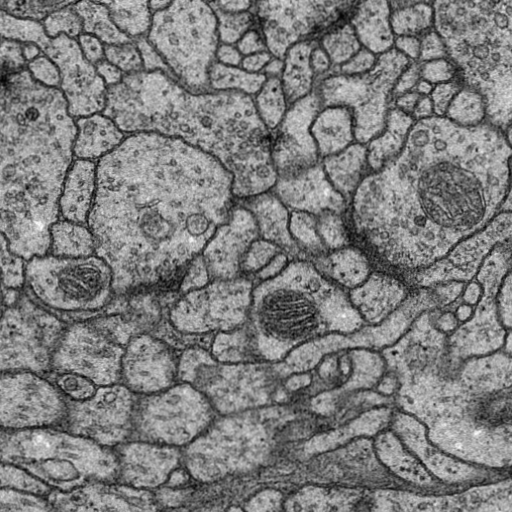

In [8]:
images.seek(1)
images

- data set : train-0.8 : val-0.1 : test-0.1

In [10]:
#train data
n_offset = 0
for i in range(24):
    images.seek(frame_id[i + n_offset])
    labels.seek(frame_id[i + n_offset])

    image = np.asarray(images)
    label = np.asarray(labels)

    np.save(os.path.join(data_dir, 'train', 'image_%03d.npy' % i), image)
    np.save(os.path.join(data_dir, 'train', 'label_%03d.npy' % i), label)

In [11]:
#val data
n_offset = 24
for i in range(3):
    images.seek(frame_id[i + n_offset])
    labels.seek(frame_id[i + n_offset])

    image = np.asarray(images)
    label = np.asarray(labels)

    np.save(os.path.join(data_dir, 'val', 'image_%03d.npy' % i), image)
    np.save(os.path.join(data_dir, 'val', 'label_%03d.npy' % i), label)

In [12]:
#val data
n_offset = 27
for i in range(3):
    images.seek(frame_id[i + n_offset])
    labels.seek(frame_id[i + n_offset])

    image = np.asarray(images)
    label = np.asarray(labels)

    np.save(os.path.join(data_dir, 'test', 'image_%03d.npy' % i), image)
    np.save(os.path.join(data_dir, 'test', 'label_%03d.npy' % i), label)

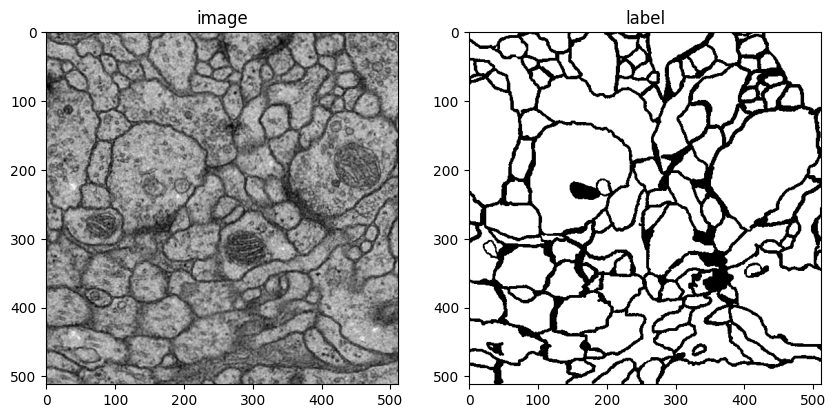

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(images, cmap='gray')
plt.title('image')
plt.subplot(122)
plt.imshow(labels, cmap='gray')
plt.title('label')
plt.show()

In [10]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 3
NUM_EPOCHS = 10

data_dir = './data'
ckpt_dir = './checkpoint'
log_dir = './log'
result_dir = './results'

if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

from ipywidgets import interact

In [12]:
import sys
sys.path.append('/content/drive/Othercomputers/내 컴퓨터/GitHub/segmentation/u-net_isbi')
import preprocessing
from preprocessing import MyDataset, ToTensor, Normalization, RandomFlip

In [37]:
data = MyDataset(data_dir=data_dir, phase='train')

In [14]:
data_ = data.__getitem__(1)

In [ ]:
data_['labels'].shape, data_['images'].shape

In [39]:
@interact(index=(0, len(data)-1))
def show_images(index=0):
    data_ = data[index]
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data_['images'].squeeze())
    plt.subplot(122)
    plt.imshow(data_['labels'].squeeze())
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=23), Output()), _dom_classes=('widget-intera…

In [17]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
data = MyDataset(data_dir=data_dir, phase='train', transform=transform)

In [18]:
data_ = data.__getitem__(0)

In [19]:
data[0]['image'].shape, data[0]['label'].shape

(torch.Size([1, 512, 512]), torch.Size([1, 512, 512]))

In [20]:
data[0]['image'].type(), data[0]['label'].type()

('torch.FloatTensor', 'torch.FloatTensor')

In [ ]:
@interact(index=(0, len(data)-1))
def show_images(index=0):
    data_ = data[index]
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data_['image'].squeeze())
    plt.subplot(122)
    plt.imshow(data_['label'].squeeze())
    plt.show()

In [22]:
dataset_train = MyDataset(data_dir=data_dir, phase='train', transform=transform)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

dataset_val = MyDataset(data_dir=data_dir, phase='val', transform=transform)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [23]:
from model import UNET

In [24]:
model = UNET().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
num_train = len(dataset_train)
num_val = len(dataset_val)

num_batch_train = np.ceil(num_train / BATCH_SIZE)
num_batch_val = np.ceil(num_val / BATCH_SIZE)

fn_to_numpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [33]:
from utils import save, load

In [34]:
model

UNET(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [41]:
st_epoch = 0
model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optimizer=optimizer)

for epoch in range(st_epoch + 1, NUM_EPOCHS + 1):
    loss_arr = []

    model.train()
    for batch, data in enumerate(loader_train, 1):
        label = data['label'].to(DEVICE)
        image = data['image'].to(DEVICE)

        pred = model(image)

        optimizer.zero_grad()
        loss = loss_fn(pred, label)
        print('L O S S : ', loss.item())
        loss.backward()
        optimizer.step()

        loss_arr += [loss.item()]

        print(f'Train Epoch {epoch} / {NUM_EPOCHS} | Batch {batch} / {num_batch_train} | Loss {np.mean(loss_arr)}')

        label = fn_to_numpy(label)
        image = fn_to_numpy(fn_denorm(image, mean=0.5, std=0.5))
        pred = fn_to_numpy(fn_class(pred))

        writer_train.add_image('image', image, num_batch_train * (epoch-1) + batch, dataformats='NHWC')
        writer_train.add_image('label', label, num_batch_train * (epoch-1) + batch, dataformats='NHWC')
        writer_train.add_image('pred', pred, num_batch_train * (epoch-1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    with torch.no_grad():
        loss_arr = []

        model.eval()
        for batch, data in enumerate(loader_val, 1):
            label = data['label'].to(DEVICE)
            image = data['image'].to(DEVICE)

            pred = model(image)

            loss = loss_fn(pred, label)
            loss_arr += [loss.item()]

            print(f'Val Epoch {epoch} / {NUM_EPOCHS} | Batch {batch} / {num_batch_val} | Loss {np.mean(loss_arr)}')

            label = fn_to_numpy(label)
            image = fn_to_numpy(fn_denorm(image, mean=0.5, std=0.5))
            pred = fn_to_numpy(fn_class(pred))

            writer_val.add_image('label', label, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
            writer_val.add_image('image', image, num_batch_val * (epoch-1) + batch, dataformats='NHWC')
            writer_val.add_image('pred', pred, num_batch_val * (epoch-1) + batch, dataformats='NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

    if epoch % 5 == 0:
        save(ckpt_dir=ckpt_dir, model=model, optimizer=optimizer, epoch=epoch)

writer_train.close()
writer_val.close()

L O S S :  -1.5498530864715576
Train Epoch 1 / 10 | Batch 1 / 8.0 | Loss -1.5498530864715576
L O S S :  -1.6269415616989136
Train Epoch 1 / 10 | Batch 2 / 8.0 | Loss -1.5883973240852356
L O S S :  -1.588285207748413
Train Epoch 1 / 10 | Batch 3 / 8.0 | Loss -1.5883599519729614
L O S S :  -1.6040315628051758
Train Epoch 1 / 10 | Batch 4 / 8.0 | Loss -1.592277854681015
L O S S :  -1.71136474609375
Train Epoch 1 / 10 | Batch 5 / 8.0 | Loss -1.616095232963562
L O S S :  -1.6083381175994873
Train Epoch 1 / 10 | Batch 6 / 8.0 | Loss -1.6148023804028828
L O S S :  -1.605238676071167
Train Epoch 1 / 10 | Batch 7 / 8.0 | Loss -1.6134361369269234
L O S S :  -1.6241090297698975
Train Epoch 1 / 10 | Batch 8 / 8.0 | Loss -1.6147702485322952
Val Epoch 1 / 10 | Batch 1 / 1.0 | Loss -2.220980167388916
L O S S :  -1.7461633682250977
Train Epoch 2 / 10 | Batch 1 / 8.0 | Loss -1.7461633682250977
L O S S :  -1.7027688026428223
Train Epoch 2 / 10 | Batch 2 / 8.0 | Loss -1.72446608543396
L O S S :  -1.86873

In [30]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='/content/log'

## Test

In [ ]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = MyDataset(data_dir=data_dir, phase='train', transform=transform)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [ ]:
num_test = len(dataset_test)

num_batch_test = np.ceil(num_test / BATCH_SIZE)

fn_to_numpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [ ]:
model, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optimizer=optimizer)


with torch.no_grad():
    loss_arr = []

    model.eval()
    for batch, data in enumerate(loader_test, 1):
        label = data['label'].to(DEVICE)
        image = data['image'].to(DEVICE)

        pred = model(image)

        loss = loss_fn(pred, label)
        loss_arr += [loss.item()]

        print(f'Test Batch {batch} / {num_batch_test} | Loss {np.mean(loss_arr)}')

        label = fn_to_numpy(label)
        image = fn_to_numpy(fn_denorm(image, mean=0.5, std=0.5))
        pred = fn_to_numpy(fn_class(pred))

        for j in range(label.shape[0]):
            id = num_batch_test * (batch - 1) + j

            plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'image_%04d.png' % id), image[j].squeeze(), camp='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'pred_%04d.png' % id), pred[j].squeeze(), cmap='gray')

            np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'image_%04d.npy' % id), image[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'pred_%04d.npy' % id), pred[j].squeeze())

print(f'Average Test Batch {batch} / {num_batch_test} | Loss {np.mean(loss_arr)}')

In [ ]:
result_dir = './results/numpy'

data_list = os.listdir(result_dir)

label_list = [f for f in data_list if f.startswith('label')]
imagae_list = [f for f in data_list if f.startswith('image')]
pred_list = [f for f in data_list if f.startswith('pred')]

label_list.sort()
imagae_list.sort()
pred_list.sort()

In [ ]:
id = 0

label = np.load(os.path.join(result_dir, label_list[id]))
image = np.load(os.path.join(result_dir, imagae_list[id]))
pred = np.load(os.path.join(result_dir, pred_list[id]))

plt.subplot(131)
plt.imshow(label)
plt.title('label')

plt.subplot(132)
plt.imshow(image)
plt.title('image')

plt.subplot(133)
plt.imshow(pred)
plt.title('pred')

plt.show()